# Web browsers use the network too sparingly

Author: alcidesv@shimmercat.com

## Abstract

The typical HTTP request/response model makes difficult for browsers to use their available bandwidth to fetch the website faster. Here we analyze how fast a web page can be fetched.

## What is in the dataset

The dataset contains page-load times, with individual resources, for each of the 1300 resource page loads.The 1300 sites were submitted by performance-conscious site operators that were evaluating their site's performance. The important bits of the dataset,  anonymized, [are available](https://github.com/shimmercat/art_timings/raw/master/data/clean_dataset.json.xz) for you to make your own measurements. 

## Notebook initialization and loading the dataset

In [1]:
# Import Bokeh modules for interactive plotting
import bokeh.io
import bokeh.mpl
import bokeh.plotting



# Seaborn, useful for graphics
import seaborn as sns

import matplotlib
#matplotlib.style.use('ggplot')
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 14, 
      'axes.titlesize': 14, 
      'axes.facecolor': 'DFDFE5',
      'patch.facecolor': 'F37626'
     }
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

%pylab
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
# %config InlineBackend.figure_formats = {'svg',}

# Set up Bokeh for inline viewing
#bokeh.io.output_notebook()

Using matplotlib backend: GTK3Agg
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
`%matplotlib` prevents importing * from pylab and numpy


In [2]:
import numpy as np
import pandas as pd
from glob import glob
import os.path
import json
import lzma
import re

In [3]:
 with lzma.open("data/clean_dataset.json.xz", 'rb') as fin:
    dataset_s = fin.read().decode('ascii')
    dataset = json.loads(dataset_s)

### Parsing the date-times

This is how the starting times of a request look in the jar file.

In [4]:
dtsample = dataset[0]['entries'][0]
dtsample

{'startedDateTime': '2015-12-01T08:37:30.598Z',
 'timings': {'blocked': 0.382999889552593,
  'connect': 248.054999858141,
  'dns': 410.19000019878143,
  'receive': 33.59492402523745,
  'send': 0.13100076466798782,
  'ssl': 215.08000046014797,
  'wait': 35.99599935114395},
 'transferSize': 20469}

Let's parse startedDateTime by hand...

In [5]:
rgx_ = re.compile( 'T([0-9]{2}):([0-9]{2}):([0-9]{2}\.[0-9]*)Z' )
ms_ = 1000
def dt2milliseconds(dtval):
    mo = re.search(rgx_, dtval)
    milliseconds = \
       int( mo.group(1) )*3600*ms_ + \
       int( mo.group(2) )*60*ms_ + \
       float( mo.group(3) )*ms_
    return milliseconds

### Decorating the entries with the relative start-end time of the request

In [6]:
def decorate_relative_timings(timings, starts_dtval, first_request_start):
    # Uses the timings entry in each fetch and its starting time 
    # to deduce a set of "unhabited" intervals and a set of 
    # "populated" intervals. 
    mseconds_start = dt2milliseconds(starts_dtval) - first_request_start
    connect = timings.get('connect',0)
    dns = timings.get('dns', 0)
    blocked = timings.get('blocked', 0)
    # Chrome uses '-1' to signal that the timing doesn't apply
    if connect < 0:
        connect = 0
    if dns < 0: 
        dns = 0
    ssl = timings.get('ssl', 0)
    if ssl < 0:
        ssl = 0
    send = timings.get('send')
    wait = timings.get('wait')
    receive = timings.get('receive')
    
    starts_receiving = mseconds_start + connect + dns + ssl + send + wait
    ends_receiving = starts_receiving + receive
    timings['rel_start'] = mseconds_start
    timings['starts_receiving'] = starts_receiving
    timings['ends_receiving'] = ends_receiving
    
def decorate_all_timing_entries(fetch_timings):
    first_fetch = fetch_timings['entries'][0]
    first_request_start = dt2milliseconds(first_fetch['startedDateTime'])
    for entry in fetch_timings['entries']:
        decorate_relative_timings(entry['timings'], entry['startedDateTime'], first_request_start)
        
for fetch_timings in dataset:
    decorate_all_timing_entries(fetch_timings)

An entry looks like this now:

In [7]:
dataset[0]['entries'][0]

{'startedDateTime': '2015-12-01T08:37:30.598Z',
 'timings': {'blocked': 0.382999889552593,
  'connect': 248.054999858141,
  'dns': 410.19000019878143,
  'ends_receiving': 943.0469246581198,
  'receive': 33.59492402523745,
  'rel_start': 0.0,
  'send': 0.13100076466798782,
  'ssl': 215.08000046014797,
  'starts_receiving': 909.4520006328823,
  'wait': 35.99599935114395},
 'transferSize': 20469}

### Sets of intervals

Sets of intervals are cool! We can do all sort of interesting things with them!

In [8]:
def merge_sets_step(s1):

    # Take the first interval
    fi = s1[0]
    fi_start, fi_end = fi 
    r_start = fi_start
    r_end = fi_end
    # Take the other intervals, and see if we can merge them
    for (_i,ai) in enumerate(s1[1:]):
        ai_start, ai_end = ai 
        if ai_start <= r_end:
            # A merge is possible 
            r_end = ai_end 
        else:
            # A merge is not possible. Since the intervals 
            # are sorted by their starting point, the next 
            # interval will start at a more distant place. 
            # Finish by returning the new merged big interval
            # and the rest of the sorted set.... 
            return ((r_start, r_end), s1[_i+1:])
    # If I arrive here, it is just a big one
    return ((r_start, r_end), [])

def merge_interval_sets(iterable_of_intervals):
    # Sort the intervals ... 
    s1 = sorted(iterable_of_intervals, key=(lambda i: i[0]))
    si = s1
    disjoint_intervals = []
    disjoint_voids = []
    mi_end_prev = None
    while len(si) > 0:
        (merged_interval, si_next) = merge_sets_step(si)
        mi_start, mi_end = merged_interval
        if mi_end_prev:
            disjoint_voids.append((mi_end_prev, mi_start))
        mi_end_prev = mi_end
        disjoint_intervals.append(merged_interval)
        si = si_next
    return (disjoint_intervals, disjoint_voids)

Let's just test a little bit the merge intervals function.

In [9]:
merge_sets_step([
        (0,1),
        (2,3)
    ])

((0, 1), [(2, 3)])

In [10]:
merge_sets_step([
        (0,1),
        (0.5,1.5),
        (2,3)
    ])

((0, 1.5), [(2, 3)])

In [11]:
merge_sets_step([
        (0,1),
        (0.5,2.5),
        (2,3)
    ])

((0, 3), [])

In [12]:
merge_interval_sets([
        (0,1),
        (0.5,2.5),
        (2,3)
    ])

([(0, 3)], [])

In [13]:
merge_interval_sets([
        (0,1),
        (0.5,1.5),
        (2,3),
        (3,4),
        (4.01, 6)
    ])

([(0, 1.5), (2, 4), (4.01, 6)], [(1.5, 2), (4, 4.01)])

In [14]:
def adv_state(state, token):
    if (state,token) == ("S0", "B1"):
        return "S1"
    if (state,token) == ("S0", "B2"):
        return "S3"
    if (state,token) == ("S1", "E1"):
        return "S0"
    if (state,token) == ("S1", "B2"):
        return "S2"
    if (state, token) == ("S2", "E2"):
        return "S1"
    if (state, token) == ('S2', 'E1'):
        return "S3"
    if (state, token) == ('S3', 'B1'):
        return "S2"
    if (state, token) == ('S3', 'E2'):
        return "S0"
    raise AssertionError("Must-not-happen: " + str((state, token)))
    return None

def diff_interval_sets(a_set, b_set):
    """Computes a \ b"""
    all_intervals = []
    for (a,b) in a_set:
        all_intervals.append(("B1",a))
        all_intervals.append(("E1",b))
        
    for (a,b) in b_set:
        all_intervals.append(("B2",a))
        all_intervals.append(("E2",b))
        
    # Now sort 
    all_intervals.sort(key=(lambda x: x[1]))
    
    state = 'S0'
    prev_position = None
    for (change, position) in all_intervals:
        #print((state,change, position, prev_position))
        new_state = adv_state(state, change)
        if state == 'S1' and new_state != 'S1':
            # This most be true for the most part  ... 
            yield (prev_position, position)
            
        state = new_state 
        prev_position = position 
    

In [15]:
list(diff_interval_sets(
        [
            (0,1),
            (1.2, 3.4)
        ],
        [
            (0.2, 0.5),
            (1.1, 3.0)
        ]
    ))

[(0, 0.2), (0.5, 1), (3.0, 3.4)]

In [16]:
list(diff_interval_sets(
        [
            (-1,2),
            (2.4, 8.4)
        ],
        [
            (2.2, 3.5),
            (3.6, 3.7)
        ]
    ))

[(-1, 2), (3.5, 3.6), (3.7, 8.4)]

Looks good, let's continue.

Number of data points
------------------------

That is, how many files there are in our little DB.

In [17]:
len(dataset)

1261

## Number of requests per page

In [18]:
counts = pd.DataFrame( list( len(d['entries']) for d in dataset ), columns=['asset_count'] )

In [19]:
counts[:5]

,asset_count
0,135
1,157
2,81
3,425
4,18


In [20]:
counts_clean = counts.query('asset_count > 5')
counts_clean['asset_count'].describe()

count    1203.000000
mean       86.600998
std        97.236518
min         6.000000
25%        26.000000
50%        55.000000
75%       109.000000
max       921.000000
Name: asset_count, dtype: float64

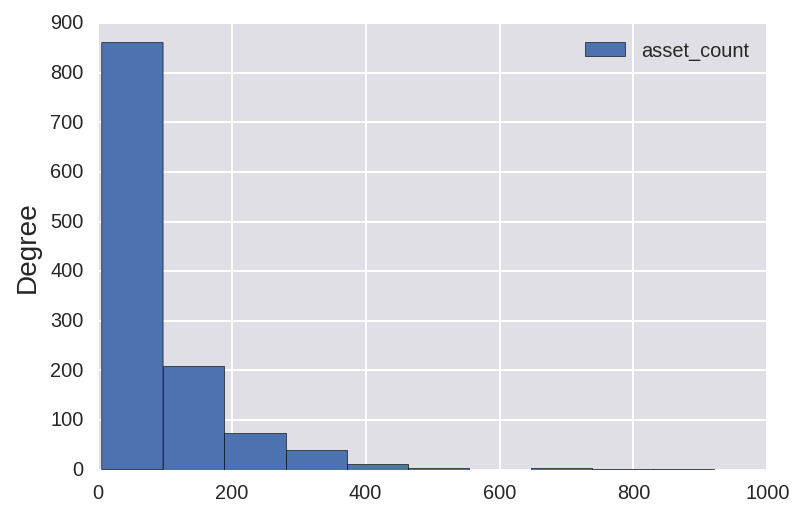

In [21]:
counts_clean.plot(kind='hist')

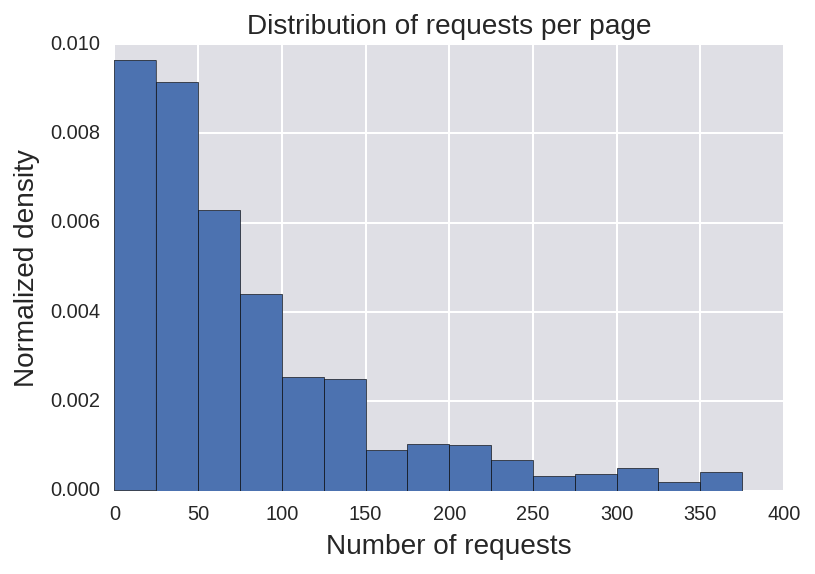

In [22]:
fig=pyplot.figure()
ax = fig.add_subplot(111)
(a0,a1,patches)=ax.hist(counts_clean.as_matrix(), bins=np.arange(0,400,25), normed=True)
a1.sum()
ax.set_xlabel("Number of requests")
ax.set_ylabel("Normalized density")
ax.set_title("Distribution of requests per page")

The number above should be used as our total of data-points: 
1233

----------------------

## When the first request can actually start

In [23]:
def extract_stoppers(entries_list):
    first_entry = entries_list[0]['timings']
    connect_time = first_entry['connect']
    dns_time = first_entry['dns']
    ssl = first_entry.get('ssl', 0)
    wait = first_entry.get('wait')
    return {
         'connect': connect_time,
         'dns': dns_time,
         'ssl': ssl,
         'wait': wait
        }

In [24]:
stoppers = list( [extract_stoppers(d['entries']) for d in dataset] )
stoppers_df = pd.DataFrame(stoppers)
stoppers_df[:5]

,connect,dns,ssl,wait
0,248.055,410.190000,215.08,35.995999
1,44.974,192.953000,-1.00,275.657000
2,166.749,182.938000,-1.00,166.886000
3,8.034,246.746000,-1.00,123.576000
4,24.032,1.269001,-1.00,30.242000


In [25]:
stoppers_df_clean = stoppers_df.query('connect > 0')
stoppers_df_clean[:5]

,connect,dns,ssl,wait
0,248.055,410.190000,215.08,35.995999
1,44.974,192.953000,-1.00,275.657000
2,166.749,182.938000,-1.00,166.886000
3,8.034,246.746000,-1.00,123.576000
4,24.032,1.269001,-1.00,30.242000


### How the bare connection times are distributed

This does not include DNS or SSL times

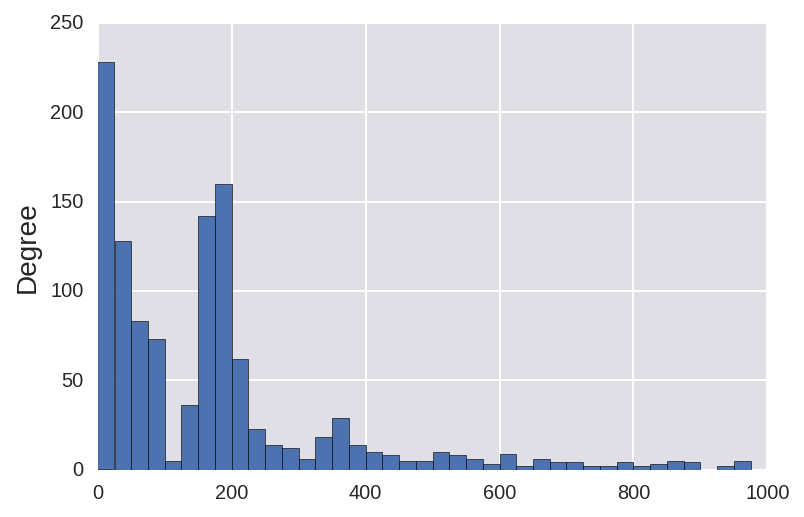

In [26]:
stoppers_df_clean['connect'].plot(kind='hist', bins=np.arange(0,1000,25))

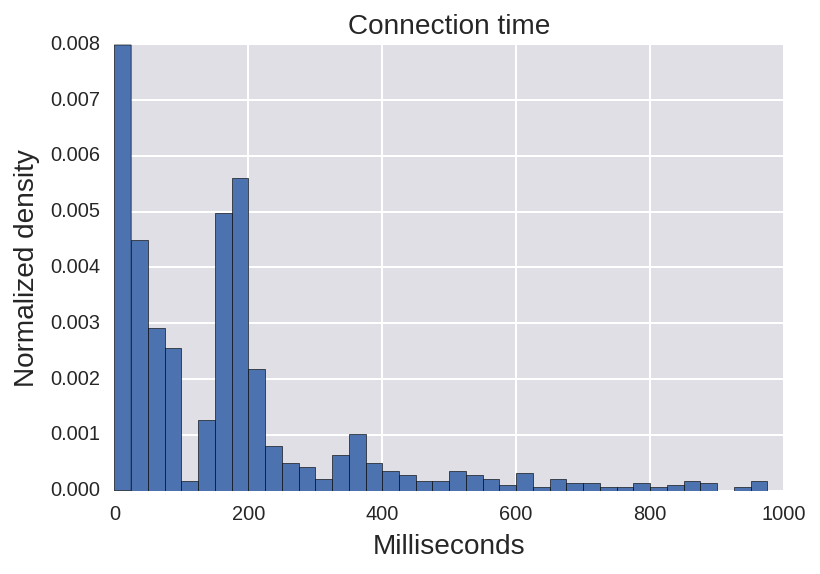

In [27]:
_data = stoppers_df_clean['connect'].as_matrix()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(_data, normed=True, bins=np.arange(0,1000,25))
ax.set_title("Connection time")
ax.set_xlabel("Milliseconds")
ax.set_ylabel("Normalized density")

In [28]:
stoppers_df_clean.describe()

,connect,dns,ssl,wait
count,1151.000000,1151.000000,1151.000000,1151.000000
mean,182.709516,176.627490,71.454324,395.762308
std,245.427672,274.765574,199.979281,620.154483
min,0.576000,0.000000,-1.000000,1.402000
25%,32.528500,17.222500,-1.000000,106.582000
50%,157.720000,76.878000,-1.000000,206.507999
75%,201.945000,210.063000,32.626000,417.026000
max,4436.960001,2661.007000,3979.796000,6569.305000


≽ There seems to be two modes. My guess for those are some sites are in EE.UU. (same place where the browser that made the measurements is located) and som are in Europe.

### How the total times are distributed for connections without SSL

In [29]:
stoppers_nossl_clean = stoppers_df_clean.query('ssl == -1')
stoppers_nossl_clean[:5]

,connect,dns,ssl,wait
1,44.974,192.953000,-1,275.657
2,166.749,182.938000,-1,166.886
3,8.034,246.746000,-1,123.576
4,24.032,1.269001,-1,30.242
8,175.758,455.540000,-1,232.651


In [30]:
full_nossl_stoppers = (
    stoppers_nossl_clean['connect']+stoppers_nossl_clean['dns']
)
full_nossl_stoppers[:5]

1    237.927
2    349.687
3    254.780
4     25.301
8    631.298
dtype: float64

In [31]:
full_nossl_stoppers.describe(percentiles=[0.05, 0.10, 0.25, 0.50, 0.75, 0.80, 0.90, 0.95])

count     763.000000
mean      308.526966
std       317.086266
min         1.459000
5%         17.092600
10%        24.941600
25%        90.488500
50%       216.578000
75%       405.002000
80%       481.743000
90%       677.265800
95%       875.118801
max      2595.431000
dtype: float64

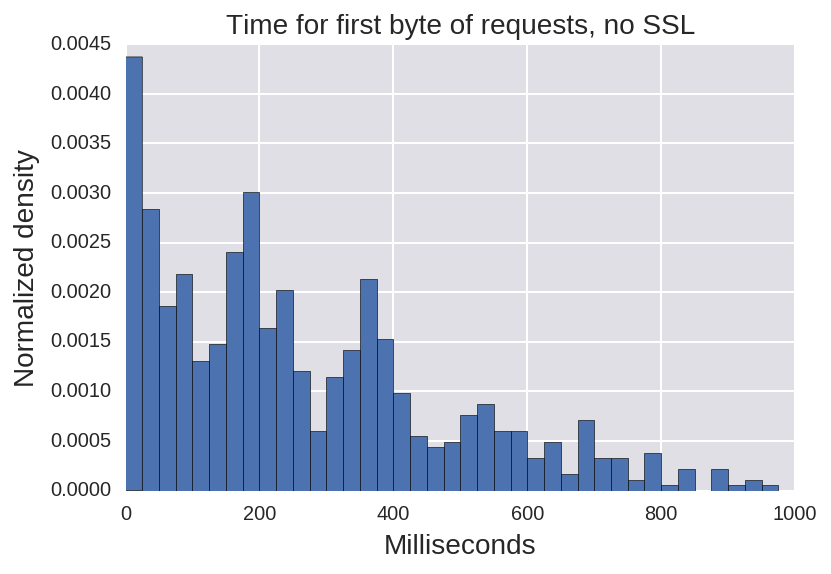

In [32]:
_data = full_nossl_stoppers.as_matrix()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(_data, normed=True, bins=np.arange(0,1000,25))
ax.set_title("Time for first byte of requests, no SSL")
ax.set_xlabel("Milliseconds")
ax.set_ylabel("Normalized density")

### How the total times are distributed for connections with SSL

In [33]:
stoppers_ssl_clean = stoppers_df_clean.query('ssl > 0')
stoppers_ssl_clean[:5]

,connect,dns,ssl,wait
0,248.055000,410.190,215.080,35.995999
5,338.042000,0.783,171.889,583.673000
6,364.349999,547.143,192.664,172.649000
7,74.965999,33.080,66.908,51.791000
9,26.235000,1.444,19.094,31.299000


#### SSL connection time

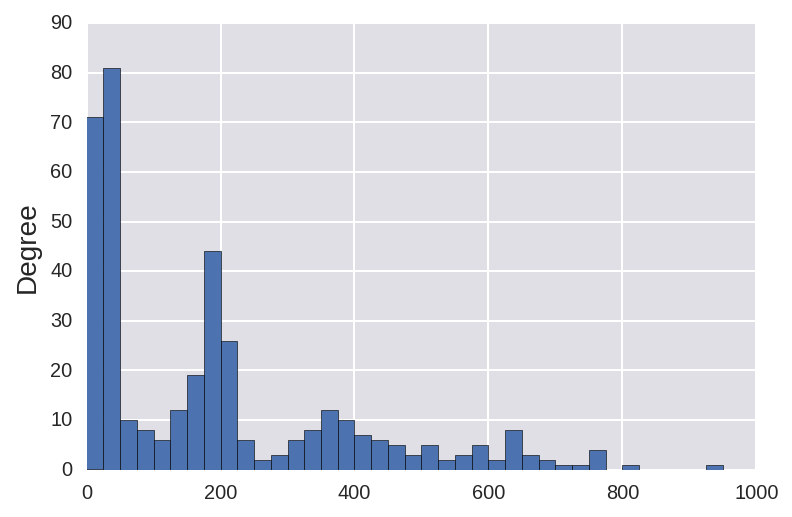

In [34]:
stoppers_ssl_clean['ssl'].plot(kind='hist', bins=np.arange(0,1000,25))

In [35]:
stoppers_ssl_clean['ssl'].describe()

count     388.000000
mean      213.935379
std       296.875515
min         9.387000
25%        32.193000
50%       157.536500
75%       313.120250
max      3979.796000
Name: ssl, dtype: float64

#### All the time that clients communicating via SSL need to wait before issuing the first request

In [36]:
full_stoppers = (
    stoppers_ssl_clean['ssl']+stoppers_ssl_clean['connect']+stoppers_ssl_clean['dns']
)
full_stoppers[:5]

0     873.325001
5     510.714000
6    1104.157000
7     174.954000
9      46.773000
dtype: float64

In [37]:
full_stoppers.describe(percentiles=[0.05, 0.10, 0.25, 0.50, 0.75, 0.80, 0.90, 0.95])

count     388.000000
mean      673.190067
std       765.692759
min        36.078000
5%         49.747650
10%        68.972600
25%       113.160000
50%       513.419000
75%       969.809500
80%      1110.823000
90%      1476.443700
95%      1829.102000
max      8416.813000
dtype: float64

That is, the mean time is well over half a second.The difference of mean with the connections that don't use SSL is 673 - 459 = 214, very close to the mean SSL connection time.

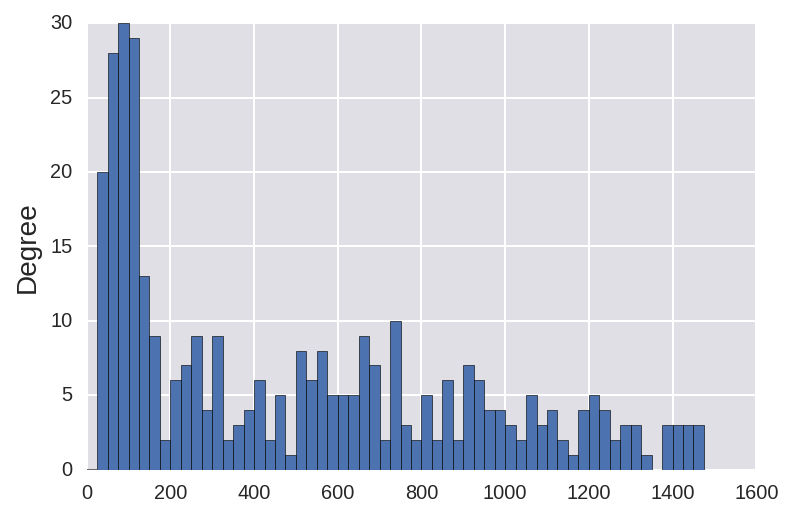

In [38]:
full_stoppers.plot(kind='hist', bins=np.arange(0,1500,25))

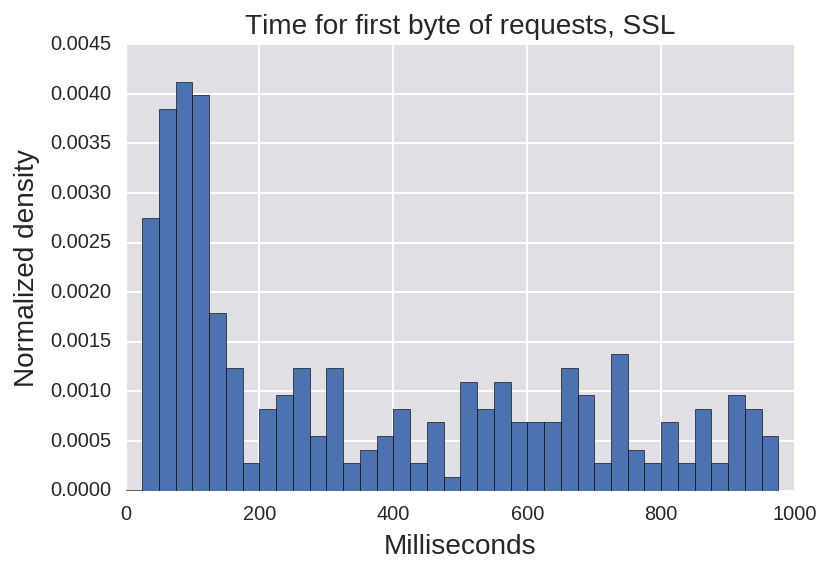

In [39]:
_data = full_stoppers.as_matrix()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(_data, normed=True, bins=np.arange(0,1000,25))
ax.set_title("Time for first byte of requests, SSL")
ax.set_xlabel("Milliseconds")
ax.set_ylabel("Normalized density")

## How much time the browser waits

In [40]:
first_entries_file = dataset[0]

In [41]:
sum( e['timings']['wait'] for e in first_entries_file['entries'][20:] )

3605.469998903569

### How much waiting time is in the first three seconds

In [42]:
def total_waiting_for_entries(entries, up_to):
    """
        @param up_to: If the relative starting time of the request is greater than this, 
                    forget about that
    """
    result = 0
    for e in entries:
        if e['timings']['rel_start'] < up_to:
            result += e['timings']['wait']
        else:
            # print(e['timings'] )
            pass
    return result

The '3000' below is given in milliseconds. That is, how much the "wait" time totals for requests that are done in the first three seconds.

In [43]:
waitings = pd.Series([ total_waiting_for_entries(entries['entries'], 3000) for entries in dataset])

In [44]:
waitings.describe()

count      1261.000000
mean       5893.788092
std       16466.981401
min           0.624000
25%        1225.002997
50%        3462.645000
75%        6512.701999
max      322341.219996
dtype: float64

Remember, this waiting time is counted in parallel: if the browser issues 20 requests in the first three seconds, and each request has a waiting timing of half a second, the result will be 20\*500 = 10000 milliseconds.

What about average waiting time?

In [45]:
def average_waiting_for_entries(entries, up_to):
    """
        @param up_to: If the relative starting time of the request is greater than this, 
                    forget about that
    """
    total = 0
    c = 0
    for e in entries:
        if e['timings']['rel_start'] < up_to:
            total += e['timings']['wait']
            c += 1
    return total/float(c)

In [46]:
avg_waitings = pd.Series([ average_waiting_for_entries(entries['entries'], 3000) for entries in dataset])

In [47]:
avg_waitings.describe()

count    1261.000000
mean      221.834544
std       595.062127
min         0.624000
25%        32.966692
50%        94.100165
75%       179.861375
max      6569.305000
dtype: float64

The number above is the average waiting time for request. 

### How much waiting time is until the "load" event

In [48]:
dataset[0]['pageTimings']

{'onContentLoad': 1311.8300437927246, 'onLoad': 1910.5799198150635}

In [49]:
def average_waiting_until_load(dts):
    total = 0
    c = 0
    up_to = dts['pageTimings']['onLoad']
    if up_to is None:
        return None
    for e in dts['entries']:
        if e['timings']['ends_receiving'] < up_to:
            total += e['timings']['wait']
            c += 1
    if c == 0:
        # Happens some times, if the onLoad event for some reason is triggered 
        # before the page is finished fetching. Can happen for special responses,
        # e.g. redirects and the link 
        return None
    return total/float(c)

def total_waiting_time_until_load(dts):
    total = 0
    up_to = dts['pageTimings']['onLoad']
    if up_to is None:
        return None
    for e in dts['entries']:
        if e['timings']['ends_receiving'] < up_to:
            total += e['timings']['wait']
    return total

In [50]:
avg_wait_till_load = pd.Series([average_waiting_until_load(dts) for dts in dataset if average_waiting_until_load(dts) is not None])

In [51]:
avg_wait_till_load.describe()

count    1133.000000
mean      119.194050
std       188.260546
min         0.000000
25%        26.485387
50%        77.511536
75%       156.177000
max      2964.742528
dtype: float64

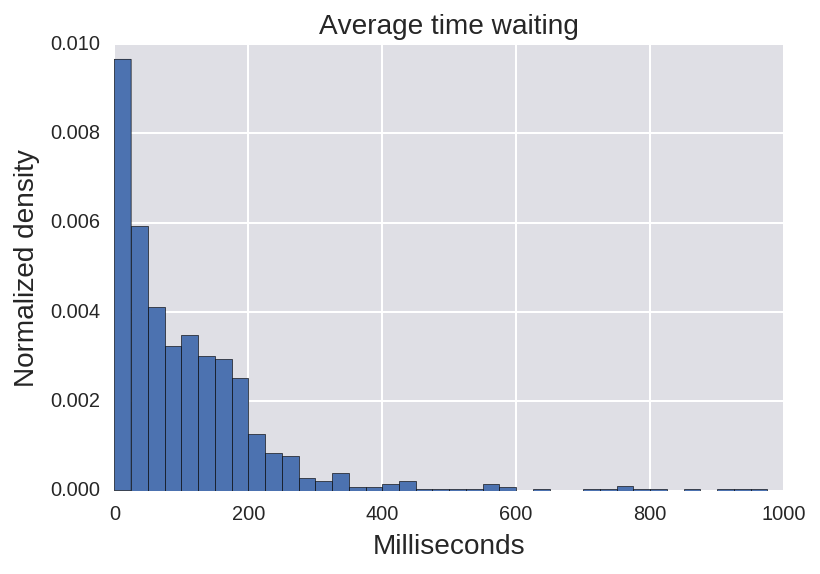

In [52]:
_data = avg_wait_till_load.as_matrix()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(_data, normed=True, bins=np.arange(0,1000,25))
ax.set_title("Average time waiting")
ax.set_xlabel("Milliseconds")
ax.set_ylabel("Normalized density")

In [53]:
tot_wait_till_load = pd.Series([total_waiting_time_until_load(dts) for dts in dataset])

In [54]:
tot_wait_till_load.describe()

count      1145.000000
mean       6926.033591
std       16068.357333
min           0.000000
25%         718.904999
50%        3222.731997
75%        7814.526000
max      304247.696998
dtype: float64

### How much time the browser is exclusively waiting

In [55]:
def wait_intervals_until_load(dts):
    total = 0
    up_to = dts['pageTimings']['onLoad']
    if up_to is None:
        return None
    for e in dts['entries']:
        timings = e['timings']
        if timings['ends_receiving'] < up_to:
            connect = timings.get('connect',0)
            dns = timings.get('dns', 0)
            blocked = timings.get('blocked', 0)
            rel_start = timings.get('rel_start')
            # Chrome uses '-1' to signal that the timing doesn't apply
            if connect < 0:
                connect = 0
            if dns < 0: 
                dns = 0
            ssl = timings.get('ssl', 0)
            if ssl < 0:
                ssl = 0
            send = timings.get('send')
            wait = timings.get('wait')


            starts_waiting = rel_start + connect + dns + ssl + send
            ends_waiting = starts_waiting + wait
            
            yield (starts_waiting, ends_waiting)
            
def disjoint_wait_intervals_until_load(dts):
    intervals = list(wait_intervals_until_load(dts))
    merged_intervals = merge_interval_sets(intervals)
    # The second part of the answer contains the voids, here we are interested 
    # only in the parts where there was a waiting...
    return merged_intervals[0]

What about the intervals where data-traffic happens?

In [56]:
def deduce_interval_optimistic(timings, starts_dtval):
    """For a given request/response pair, returns the interval 
       where data is being transferred to the browser """
    mseconds_start = timings['rel_start']
    connect = timings.get('connect',0)
    dns = timings.get('dns', 0)
    blocked = timings.get('blocked', 0)
    # Chrome uses '-1' to signal that the timing doesn't apply
    if connect < 0:
        connect = 0
    if dns < 0: 
        dns = 0
    ssl = timings.get('ssl', 0)
    if ssl < 0:
        ssl = 0
    send = timings.get('send')
    wait = timings.get('wait')
    receive = timings.get('receive')
    
    starts_receiving = mseconds_start + connect + dns + ssl + send + wait
    ends_receiving = starts_receiving + receive
    return (starts_receiving, ends_receiving)

def summarize_intervals_from_entries(dts):
    """
    Returns a set of merged intervals where there is 
    data transfer from the server to the browser.
    """
    entries = dts['entries']
    if len(entries) <= 2:
        return None
    # returns a data frame with the void times, their lengths, 
    # the void_end and so so...
    all_file_intervals = [
        deduce_interval_optimistic(entry['timings'], entry['startedDateTime'])
        for entry in entries
    ]
    # Two sets of complimentary, non overlapping intervals. 
    # The first set (non overlapping) intervals represents when data is being received 
    # from the server. The second set  represents when no data is being received.
    data_traffic_intervals, void_intervals = merge_interval_sets(all_file_intervals)
    return data_traffic_intervals

Let's compute the intervals for the first set just to see that the calculations make sense:

In [57]:
wait_intervals = disjoint_wait_intervals_until_load(dataset[0])
wait_intervals[:4]

[(755.135999172926, 806.6849999576802),
 (855.605000577867, 947.1300000548364),
 (979.33999979496, 1042.2140003219251),
 (1045.553001128137, 1239.5879996344447)]

In [58]:
data_transfer_intervals = summarize_intervals_from_entries(dataset[0])
data_transfer_intervals[:4]

[(781.1789994761343, 782.8819367736577),
 (788.6800003424287, 789.0669974684715),
 (795.882000371814, 796.6599555388093),
 (802.104999423027, 804.4668221399189)]

In [59]:
list( diff_interval_sets(wait_intervals, data_transfer_intervals) )[:4]

[(755.135999172926, 781.1789994761343),
 (782.8819367736577, 788.6800003424287),
 (789.0669974684715, 795.882000371814),
 (796.6599555388093, 802.104999423027)]

Exclusively waiting total (before the load event):

In [60]:
def exclusively_waiting_total(dts):
    wait_intervals = disjoint_wait_intervals_until_load(dts)
    data_transfer_intervals = summarize_intervals_from_entries(dataset[0])
    exclusively_waiting_intervals = diff_interval_sets(wait_intervals, data_transfer_intervals)
    
    s = 0.0
    for (a,b) in exclusively_waiting_intervals:
        s += (b - a)
    return s

In [61]:
exclusively_waiting_total(dataset[5])

652.7602814957474

Now we can check a distribution for everybody:

In [62]:
waiting_series = pd.Series([exclusively_waiting_total(dts) for dts in dataset])

In [63]:
waiting_series.describe()

count    1261.000000
mean     1187.966479
std      1319.171288
min         0.000000
25%       195.649000
50%       780.243429
75%      1657.775244
max      7862.061900
dtype: float64

How much is that waiting time compared to the load event?

In [84]:
def proportion_just_waiting(dts):
    exclusively_waiting = exclusively_waiting_total(dts)
    load_time = dts['pageTimings']['onLoad']
    if load_time is None:
        return float('nan')
    return exclusively_waiting / load_time

proportion_just_waiting(dataset[12])

0.2978779370419944

In [86]:
waiting_proportion = pd.Series([proportion_just_waiting(dts) for dts in dataset])
waiting_proportion.describe()

count    1145.000000
mean        0.392320
std         0.188519
min         0.000000
25%         0.246101
50%         0.390646
75%         0.528817
max         0.884145
dtype: float64

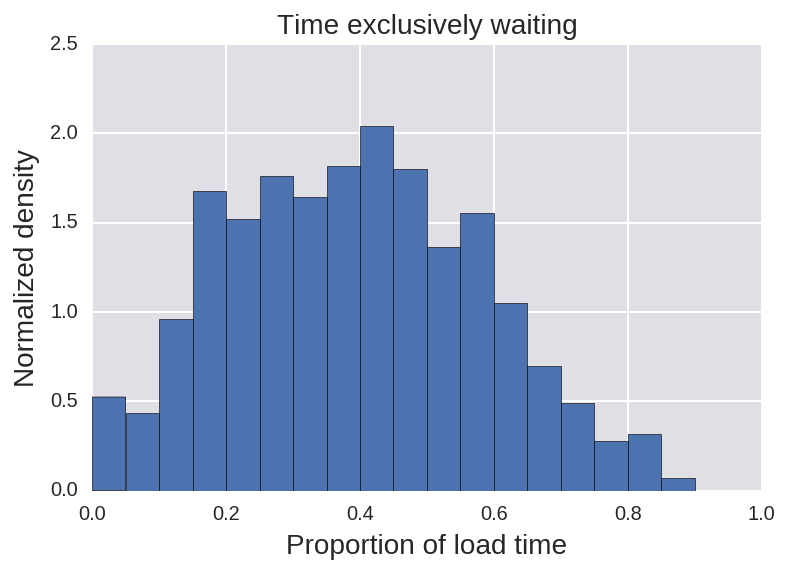

In [98]:
_data = waiting_proportion.as_matrix()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(_data, normed=True, bins=np.arange(0,1,0.05))
ax.set_title("Time exclusively waiting")
ax.set_xlabel("Proportion of load time")
ax.set_ylabel("Normalized density")

## How much remains unused

This section explores which part of the loading time of web pages goes empty, meaning that no data is being received by the browser.

### Deducing the intervals from the timings

Using the 'timings' key in the dataset entries, and the started time, let's deduce an interval as a tuple with the start and end time in milliseconds.

The function below takes all the intervals, merges and summarizes them. However, instead of looking to the time when data is being received, we look to the part when data is **not** being received. We call those intervals when the browser is not receiving data from the network, *voids*.

This is how it looks for a single entry in the dataset:

In [67]:
file_entries = dataset[0]

summary = summarize_intervals_from_entries(file_entries)
summary[:5]

[(781.1789994761343, 782.8819367736577),
 (788.6800003424287, 789.0669974684715),
 (795.882000371814, 796.6599555388093),
 (802.104999423027, 804.4668221399189),
 (805.353000551462, 807.748070381582)]

In the list above, the numbers represent milliseconds since the start of the page fetch. Each tuple is a separate interval where the browser is receiving data.

## Shimmercat data

In [87]:
def clean_entry(src_entry):
    trg_entry = {}
    trg_entry['timings'] = src_entry['timings']
    trg_entry['startedDateTime'] = src_entry['startedDateTime']
    trg_entry['transferSize'] = src_entry['response']['_transferSize']
    
    return trg_entry

def clean_har_record(har_record):
    entries = har_record['entries']
    clean_entries = []
    is_first_entry = True 
    for e in entries:
        ee = clean_entry(e)
        if is_first_entry:
            timing_ref = e['pageref']
            for page in har_record['pages']:
                if page['id'] == timing_ref:
                    timing_data = page['pageTimings']
            is_first_entry = False
        clean_entries.append( ee )
    obj = {
        'entries': clean_entries,
        'pageTimings': timing_data
    }
    return obj

def fetch_and_standardize_entries(filename):
    data = json.load(open(filename))['log']
    decorate_all_timing_entries(data)
    o_data = clean_har_record(data)
    return o_data

In [88]:
shimmercat_data = fetch_and_standardize_entries( 'data/www.shimmercat.com.har' ) 

average_waiting_until_load(shimmercat_data)

13.827609755070423

In [89]:
proportion_just_waiting(shimmercat_data)

0.09932061822044232

## Data for some other sites

In [90]:
wikipedia_data = fetch_and_standardize_entries( 'data/en.wikipedia.org.har' )

proportion_just_waiting(wikipedia_data)

0.47653730750799056

In [91]:
so_data = fetch_and_standardize_entries('data/stackoverflow.com.har')

proportion_just_waiting(so_data)

0.2824579220730195

In [92]:
mozilla_data = fetch_and_standardize_entries('data/developer.mozilla.org.har')
proportion_just_waiting(mozilla_data)

0.11885837530498636

In [93]:
exclusively_waiting_total(mozilla_data)

1141.3018913536798

In [94]:
exclusively_waiting_total(shimmercat_data)

175.49685073934975

In [95]:
exclusively_waiting_total(so_data)

1472.8008534681883

In [96]:
exclusively_waiting_total(wikipedia_data)

518.7080000001589